# Data Banks

### Modelos de Machine Learning Bancarios.

#### Primer Modelo: Predicción de nuevas sucursales de bancos:
  - El número de nuevos bancos a instalar es definido por el usuario.
  - Utiliza aprendizaje no supervisado, específicamente el algoritmo de K-Means clustering.

#### Segundo Modelo: Sistema de Recomendación de servicios financieros a clientes.
  - Sugiere dos servicios financieros diferentes a los usuarios de acuerdo a sus satisfacción con su servicio bancario.
  - Utiliza aprendizaje supervisado, específicamente RandomForestClassifier.



### Primer Modelo: Predicción de nuevas sucursales de bancos

  - Hemos empleado técnicas avanzadas de aprendizaje no supervisado, específicamente el algoritmo de K-Means clustering, con el objetivo de proporcionar un sistema de recomendación para la ubicación de nuevos bancos.

  - Para llevar a cabo este análisis, utilizamos un conjunto de datos que incluye las coordenadas geográficas y las calificaciones promedio de los bancos existentes.

  - El código implementa el algoritmo K-Means en las ubicaciones de los bancos con calificaciones promedio por debajo de cierto umbral. El número de nuevos bancos a instalar es definido por el usuario, y el algoritmo agrupa estas ubicaciones para determinar los centroides, que representan las ubicaciones óptimas para los nuevos bancos.

Importo librerías y configuraciones

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('io.parquet.engine', 'fastparquet')

Cargo mi dataframe.

In [3]:
dfMetadata = pd.read_csv("data/Cloud Upload/Google Maps/metadata.csv")
dfMetadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23581 entries, 0 to 23580
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            23581 non-null  object 
 1   gmap_id         23581 non-null  object 
 2   latitude        23581 non-null  float64
 3   longitude       23581 non-null  float64
 4   avg_rating      23581 non-null  float64
 5   num_of_reviews  23581 non-null  int64  
 6   url             23581 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.3+ MB


In [5]:
dfBusinessSnappy = pd.read_csv("data/Cloud Upload/Yelp/business.csv")
dfBusinessSnappy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   749 non-null    object 
 1   name          749 non-null    object 
 2   city          749 non-null    object 
 3   state         749 non-null    object 
 4   postal_code   749 non-null    object 
 5   latitude      749 non-null    float64
 6   longitude     749 non-null    float64
 7   stars         749 non-null    float64
 8   review_count  749 non-null    int64  
 9   is_open       749 non-null    int64  
 10  categories    749 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 64.5+ KB


Creo mi modelo

Coordenadas de los nuevos bancos con estados:
     Latitud    Longitud Estado
0  30.855233  -82.451807     AZ
1  37.674667 -108.481997     FL
2  34.429700  -95.151304     DE
3  38.285938 -120.016835     NJ
4  40.548418  -78.690770     TN


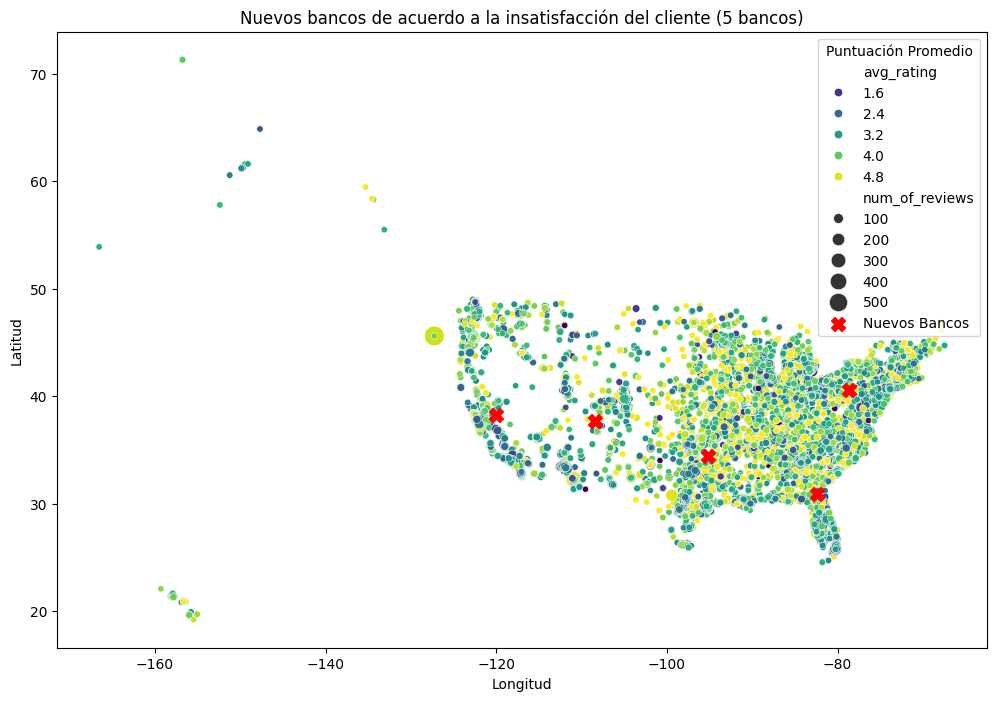

In [6]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que dfMetadata y dfBusinessSnappy ya fueron cargados previamente

def generar_nuevos_bancos(num_new_banks, min_rating):
    # Accedo a los dataframes dfMetadata y dfBusinessSnappy
    # (Estos dataframes están definidos fuera de la función)

    # Seleccionar las ubicaciones donde avg_rating es menor al valor especificado
    locations_to_cluster = dfMetadata[dfMetadata['avg_rating'] < min_rating][['latitude', 'longitude']].values

    # Aplicar KMeans para encontrar los centroides
    kmeans = KMeans(n_clusters=num_new_banks, random_state=42)
    kmeans.fit(locations_to_cluster)

    # Obtener las ubicaciones de los nuevos bancos (centroides)
    new_banks_centroids = kmeans.cluster_centers_

    # Crear un DataFrame con las coordenadas de los nuevos bancos
    df_nuevos_bancos = pd.DataFrame({
        'Latitud': new_banks_centroids[:, 0],
        'Longitud': new_banks_centroids[:, 1]
    })

    # Agregar la columna 'Estado' al DataFrame de los nuevos bancos
    df_nuevos_bancos['Estado'] = df_nuevos_bancos.apply(lambda row: obtener_estado_cercano(row), axis=1)

    # Imprimir el DataFrame de los nuevos bancos con coordenadas y estados
    print("Coordenadas de los nuevos bancos con estados:")
    print(df_nuevos_bancos)

    # Mapa de dispersión geoespacial con centroides en rojo.
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='longitude', y='latitude', data=dfMetadata, hue='avg_rating', palette='viridis', size='num_of_reviews', sizes=(20, 200))
    plt.scatter(new_banks_centroids[:, 1], new_banks_centroids[:, 0], c='red', marker='X', s=100, label='Nuevos Bancos')
    plt.title(f'Nuevos bancos de acuerdo a la insatisfacción del cliente ({num_new_banks} bancos)')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.legend(title='Puntuación Promedio')
    plt.show()

    return df_nuevos_bancos

def obtener_estado_cercano(row):
    # Función para obtener el estado más cercano a una ubicación dada
    min_distance = float('inf')
    nearest_state = None

    for _, business_row in dfBusinessSnappy.iterrows():
        location_business = (business_row['latitude'], business_row['longitude'])
        distance = ((row['Latitud'] - location_business[0])**2 + (row['Longitud'] - location_business[1])**2)**0.5

        if distance < min_distance:
            min_distance = distance
            nearest_state = business_row['state']

    return nearest_state

# Ejemplo de uso
num_new_banks = 5
min_rating = 3  # Modifica este valor según tus necesidades
nuevos_bancos_df = generar_nuevos_bancos(num_new_banks, min_rating)

  - Primer argumento: numero de bancos.
  - Segundo Argumento: nota a partir de la cual toma en cuenta las sucursales. (mayor a 1)

Coordenadas de los nuevos bancos con estados:
     Latitud    Longitud Estado
0  38.876364  -86.350908     IN
1  37.187258 -118.109165     AZ
2  33.110238  -97.472074     PA
3  28.080476  -81.141021     TN
4  39.628291  -75.778731     TN


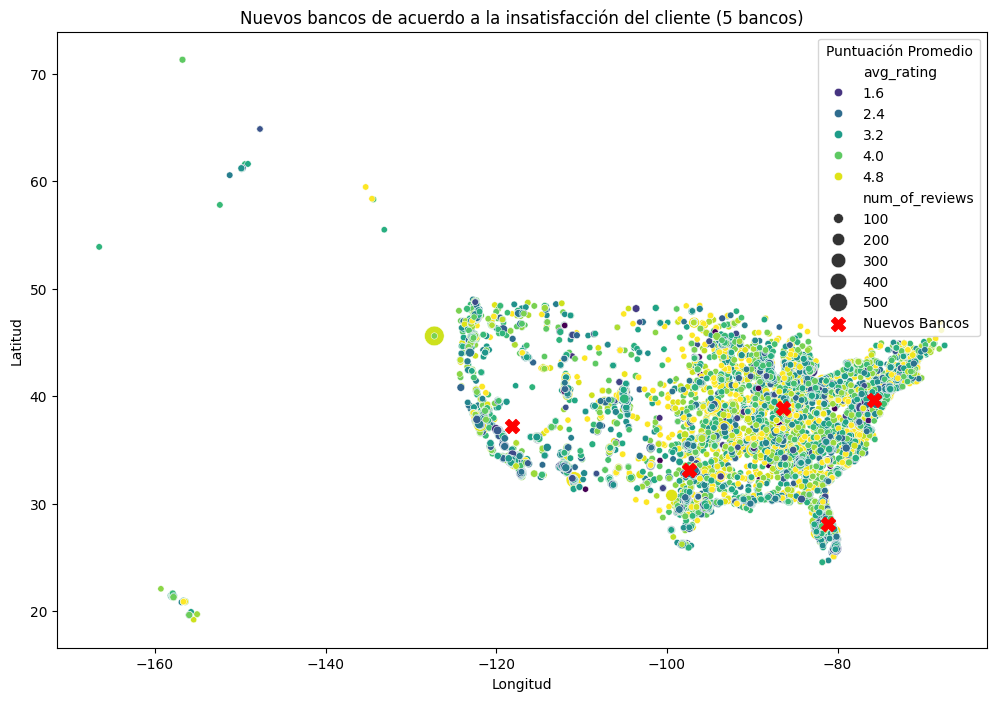

In [7]:
nuevos_bancos_df = generar_nuevos_bancos(5, 2)

### Segundo Modelo: Sistema de recomendación de sistemas bancarios.

  - Este algoritmo construye múltiples árboles de decisión durante el entrenamiento y fusiona sus resultados para obtener predicciones más robustas y generalizadas. Cada árbol de decisión en el bosque se entrena con diferentes subconjuntos aleatorios de características y observaciones, lo que reduce el riesgo de sobreajuste y mejora la capacidad de generalización del modelo.

  - El argumento de entrada al modelo es el "user_id", al cual se le recomendará un servicio bancario.

  #### Planes Ofrecidos por el sistema de recomendación de a los clientes.

##### 1. ElitePlus Banking Experience (Clientes Satisfechos - Alto Rating):

  - Tasas Preferenciales: Ofrecemos tasas de interés hasta un 1% más bajas en productos financieros como préstamos y cuentas de ahorro.
  - Asesoramiento Financiero Personalizado: Acceso a asesores financieros dedicados para planificación personalizada y optimización de inversiones.
  - Eventos Exclusivos: Invitaciones a eventos exclusivos, como cenas VIP, presentaciones financieras y networking con expertos del sector.
  - Recompensas por Lealtad: Programa de recompensas que acumula puntos por cada transacción y que pueden canjearse por descuentos en servicios o productos.


##### 2. FreshStart Financial Solutions (Clientes Insatisfechos - Bajo Rating):

  - Tasas Competitivas de Inicio: Tasas de interés iniciales competitivas, incluso para aquellos con historial crediticio menos favorable.
  - Herramientas de Gestión Financiera: Plataforma digital con herramientas avanzadas para el seguimiento y la gestión de finanzas personales.
  - Programa de Reestructuración de Deudas: Opciones para consolidar deudas y establecer planes de pago flexibles.
  - Bonificaciones por Cambio: Bonificaciones especiales al realizar la transición, como la exención de tarifas durante los primeros seis meses.

Importo Liberías.

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Cargo Dataframe.

In [9]:
dfReviewsSnappy = pd.read_csv("data/Cloud Upload/Google Maps/reviews.csv")
dfReviewsSnappy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62867 entries, 0 to 62866
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  62867 non-null  float64
 1   name     62867 non-null  object 
 2   time     62867 non-null  object 
 3   rating   62867 non-null  int64  
 4   text     62867 non-null  object 
 5   gmap_id  62867 non-null  object 
 6   date     62867 non-null  object 
 7   hour     62867 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 3.8+ MB


Creo mi modelo.

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Suprimir la advertencia sobre los nombres de las características
warnings.filterwarnings("ignore", category=UserWarning)

# Asignar nombres a las características
dfReviewsSnappy['user_id'] = dfReviewsSnappy['user_id']

# Definir umbral de satisfacción
umbral_satisfaccion = dfReviewsSnappy['rating'].mean()

# Crear variable objetivo (target)
dfReviewsSnappy['target'] = dfReviewsSnappy['rating'].apply(lambda x: 1 if x >= umbral_satisfaccion else 0)

# Seleccionar características relevantes (en este caso, solo user_id)
X = dfReviewsSnappy[['user_id']]
y = dfReviewsSnappy['target']

# Dividir conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Función para recomendar servicios financieros basada en el user_id
def recomendar_servicio(user_id):
    # Predecir la satisfacción del usuario
    satisfaction_prediction = model.predict([[user_id]])[0]

    # Ofrecer servicio basado en la predicción
    if satisfaction_prediction == 1:
        return "¡Te recomendamos nuestro exclusivo servicio ElitePlus Banking Experience!"
    else:
        return "Descubre nuestro servicio FreshStart Financial Solutions para mejorar tu experiencia financiera."

Accuracy: 0.5318912040718944
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.52      0.52      6093
           1       0.55      0.54      0.55      6481

    accuracy                           0.53     12574
   macro avg       0.53      0.53      0.53     12574
weighted avg       0.53      0.53      0.53     12574



In [12]:
# Ejemplo de uso
# Plan 1: 1.030135e+20
# Plan 2: 1.059413e+20
user_id_ejemplo = 1.059413e+20  # Ajusta este valor según tus datos reales
recomendacion = recomendar_servicio(user_id_ejemplo)
print(recomendacion)

¡Te recomendamos nuestro exclusivo servicio ElitePlus Banking Experience!
